## Resampling

In [2]:

import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt



In [4]:
    # This is Google Analytics data
    # The result is a total of 36 sessions for the two different presentations, 21 for page A and 15 for page B

session_times = pd.read_csv('web_page_data.csv')
session_times.Time = 100 * session_times.Time
session_times.head()

    # counting 
count_A = (session_times.Page == 'Page A').sum()
count_B = (session_times.Page == 'Page B').sum()
count_TOT = session_times.shape[0]

print("Total observations {}. \nPage A: {}   Page B: {}".format(count_TOT,count_A, count_B ) )


session_times.head()


Total observations 36. 
Page A: 21   Page B: 15


,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


#### Boxplots

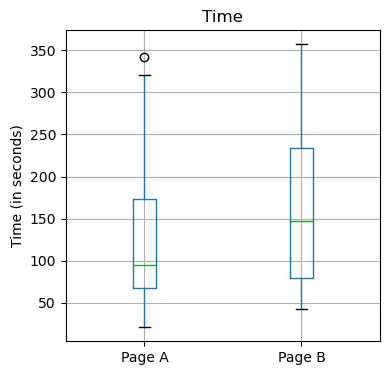

In [6]:
    # Creates a boxplot:
    # session_times.boxplot: This method generates a boxplot using the data in the pandas DataFrame session_times
    # by='Page': Groups the data by the Page column, creating a separate boxplot for each unique value in the Page column.
    # column='Time': Specifies that the Time column values are used to create the boxplots.
    # ax: The plot's axes object is returned and stored in the variable ax.

ax = session_times.boxplot(by='Page', column='Time', figsize=(4, 4))

    # Removes the x-axis label by setting it to an empty string ('').
ax.set_xlabel('')

ax.set_ylabel('Time (in seconds)')

    # Removes the default title ("Boxplot grouped by Page") generated by pandas, leaving it blank.
plt.suptitle('')

    # Adjusts the layout of the plot to ensure that all elements fit neatly within the figure, avoiding overlaps or cutoff labels.
plt.tight_layout()
plt.show()

The boxplot, shown in Figure 3-3, indicates that page B leads to longer sessions than page A. 

### More on ax objects

In Matplotlib, a plot is built on a figure (the overall canvas) and contains one or more axes (subplots or individual plots). An axes object represents the area of the figure where data is plotted. It includes:

    The plot itself (e.g., lines, bars, or boxplots).
    The axes (x-axis and y-axis), including their labels, ticks, and scales.
    Titles, legends, and other visual elements.


#### What is Stored in ax?

The ax variable stores the reference to the axes object for the boxplot. This allows you to customize the plot further, such as setting labels, changing titles, or adding additional elements like annotations.

#### Why is ax Useful?

The ax object acts like a handle to the specific plot, allowing you to apply changes or retrieve information about the plot programmatically. If you create multiple subplots, you can have different ax objects to control each subplot individually.

Think of ax as a remote control for the specific plot it corresponds to. With this "remote," you can adjust various settings for the plot (axes labels, titles, grid lines, etc.).

#### Why use ax?

    It can be called any other name, ax it’s short and descriptive.
    It's a widely recognized convention, so it makes your code easier to understand for others (and your future self).

### Means

In [8]:
    # We can calculate the mean for each group:

    # we filter the pandas data frame first by page and then determine the mean of the Time column:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(f"Mean A: {mean_a:.2f}   Mean B: {mean_b:.2f}")
print(f"Difference in the means: {(mean_b - mean_a):.2f}")
print (f"Page B has session times that are greater than those of page A by {(mean_b - mean_a):.2f} seconds, on average.")

Mean A: 126.33   Mean B: 162.00
Difference in the means: 35.67
Page B has session times that are greater than those of page A by 35.67 seconds, on average.


In [10]:
    # Very interesting filtering:
    # This gives "True/False map" of whether values are 'Page A':
session_times_Page_A = session_times.Page == 'Page A'
print(session_times_Page_A.head())

    # And we can use that to filter just the elements with "Page A"
session_times[session_times.Page == 'Page A'].head()

0     True
1    False
2     True
3    False
4     True
Name: Page, dtype: bool


,Page,Time
0,Page A,21.0
2,Page A,35.0
4,Page A,67.0
6,Page A,211.0
8,Page A,132.0


Page B has session times that are greater than those of page A by 35.67 seconds, on average. 

The question is whether this difference is within the range of what random chance might produce, i.e., is statistically significant. 

One way to answer this is to apply a permutation test—combine all the session times together and then repeatedly shuffle and divide them into groups of 21 (recall that nA = 21 for page A) and 15 (nB = 15 for page B).

### Permutation Test

To apply a permutation test, we need a function to randomly assign the 36 session times to a group of 21 (page A) and a group of 15 (page B).

In [158]:
# This function is implementing what's called a random permutation or reshuffling of the data. 
# Think of it like randomly dealing cards into two piles, where the size of each pile matches your original groups.

def perm_fun(x, nA, nB):

    # The function takes three parameters:
    # x: Your data (in this case, the 'Time' column:   session_times.Time  )
    # nA: The size of group A (number of Page A observations)
    # nB: The size of group B (number of Page B observations)

#The code first calculates the total number of observations (n = nA + nB). 
    n = nA + nB  

# Then, instead of actually shuffling the data, it creates two sets of indices 
# that will be used to split the data into new random groups. This is more efficient than shuffling the actual values.

# The next line randomly selects nB numbers from the range 0 to n-1, representing the indices for group B. 
    
# random.sample() function: returns a particular length list of items chosen from the sequence. 
# Used for random sampling without replacement. 
# this is then converted to a set in order to enable the set subtraction operation that comes next
    
    idx_B = set(random.sample(range(n), nB))

# This subtracts the list of index_B from the total list of indexes, to obtain index_A
    idx_A = set(range(n)) - idx_B

# .loc is a pandas DataFrame accessor that lets you select data using labels/indices in a very precise way. 
# like using an index in a book - if you have specific page numbers you want to look up, .loc helps you find exactly those pages.
#  x.loc[list(idx_B)] means "get me the values from x at indices found in idx_B"
# idx_B is converted to a list because .loc works better with lists.

# then we take the mean for each group, and find the difference
    
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]

print(perm_fun(session_times.Time, nA, nB))


35.09523809523809




Calling this function R = 1,000 times and specifying nA = 21 and nB = 15 leads to a distribution of differences in the session
times that can be plotted as a histogram.

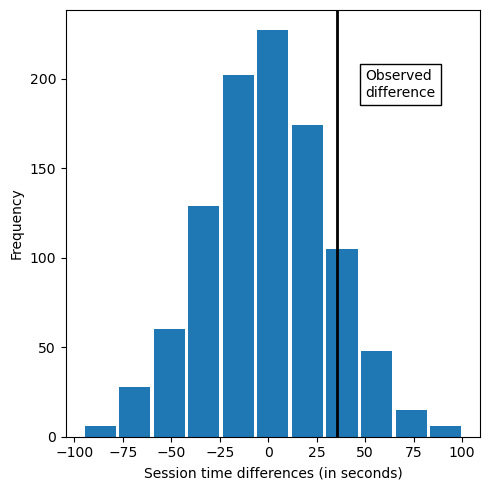

In [154]:
    # This ensures we get the same random results each time - very useful for reproducibility

random.seed(1)


    # This executes the "perm_fun" function 1000 times and stores the result in the "perm_diffs" list
    # This line runs our permutation function 1000 times, creating what we call a "null distribution" - 
    # it shows us what differences we might see just by chance if there were no real effect between groups A and B. 

perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]


    # Now we create the visualization:

fig, ax = plt.subplots(figsize=(5, 5))

    # The histogram shows the distribution of our permuted differences:
ax.hist(perm_diffs, bins=11, rwidth=0.9)

    # Then we add a vertical line showing our actual observed difference:
ax.axvline(x = mean_b - mean_a, color='black', lw=2)

ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()



The resulting visualization tells us something important: if the black line (our actual observed difference) falls far into the tails of the histogram, it suggests that the difference we observed is unlikely to have occurred by chance. If it falls in the middle of the distribution, it suggests our observed difference could easily have occurred randomly.

The histogram shows that mean difference of random permutations often exceeds the observed difference in session times (the vertical line). For our results, this happens in 12.1% of the cases (see below)

In [168]:
    # convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)

    # perm_diffs > mean_b - mean_a compares every value in our permutation differences to our observed difference (mean_b - mean_a). 
    # This creates an array of True/False values.
    
print(np.mean(perm_diffs > mean_b - mean_a))




0.121


In [196]:
differences_array = (perm_diffs > mean_b - mean_a)
print("Array of differences: ", differences_array[0:20], "...")
print ("Its mean: ",  differences_array.mean())


Array of differences:  [False False False False False False False False False False False False
  True  True False False False  True False False] ...
Its mean:  0.121


### More on the "null distribution"

Let me explain the concept of a null distribution by building up from fundamentals.
In statistics, when we're comparing two groups (like Page A and Page B in your example), we start with a "null hypothesis" - a baseline assumption that there's no real difference between the groups. Any differences we see would just be due to random chance. This is similar to how if you flip a fair coin 10 times, you might get 7 heads and 3 tails even though the true probability is 50-50. That difference from exactly 5-5 is just random variation.


The null distribution shows us what kind of differences we might see purely by chance if there truly was no effect. In your code, we create this distribution through simulation: we repeatedly shuffle all the data randomly into two groups (maintaining the original group sizes) and calculate the difference between these randomly-assigned groups each time.

### Example

Think of it like this: Imagine you have 20 people's heights written on cards - 10 from Minneapolis and 10 from St. Paul. Your actual data shows Minneapolis people are 2 inches taller on average. Is this a real difference, or could it have happened by chance? To find out, you could:

Mix all 20 cards together
Randomly deal them into two piles of 10 each
Calculate the difference in averages between these random piles
Repeat this process 1000 times

The collection of these 1000 random differences forms your null distribution. It tells you what kind of differences you might see just by chance when there's no real underlying difference between the groups.

If your actual observed difference (shown by the black line in your plot) is far outside this null distribution, it suggests that the difference you observed is unlikely to have occurred by chance alone. 

### Fig and Ax

In Matplotlib, there are two main objects that work together to create visualizations:

The Figure (which we store in fig) is like a blank canvas or piece of paper. It's the outer container that holds everything - it manages the space where your plots will live and handles things like saving to files or displaying on screen. Think of it as the entire window or image that will contain your visualization.

The Axes (which we store in ax) is like a specific drawing area within that canvas where your actual plotting happens. This is where you call methods like .plot(), .hist(), or .scatter(). The Axes object manages things like the coordinate system, labels, ticks, and the actual data visualization.

The function plt.subplots() creates both of these objects at once and returns them as a tuple. It's called "subplots" because it can create multiple plotting areas (multiple Axes) within one Figure.


The figsize=(5, 5) parameter is telling Matplotlib to create a square Figure that's 5 inches by 5 inches. Then you use the ax object to create your histogram and add other elements

While we don't explicitly call methods on fig, it's still actively working behind the scenes. Let me explain with an analogy.

Think of fig like a photo frame and ax like the photo inside it. When you adjust the photo (using ax), you're working within the frame's boundaries. The frame (fig) is still essential - it's holding everything together and controlling the overall size and properties, even if we're not directly touching it.

We're creating a 5-inch by 5-inch frame. After that, everything we do with ax is constrained by and displayed within that frame. The fig object is still actively managing:

- The overall size of the visualization
- The mapping between screen coordinates and figure coordinates
- The rendering of the entire visualization
- Memory management for the plot
- The connection to the display system or file output

These commands are actually working with our fig object behind the scenes. We could write them more explicitly as:
fig.tight_layout()
fig.show()
